*Attention : J'ai utilisé un outil pour entrer des variables dans des chaînes de caractères qui nécessite Python 3.6 ou une version supérieure.*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

L'analyse qui suit porte sur le trafic voyageurs entrant dans chaque station du réseau ferré RATP (des lignes de métro et des RER A et B, à l'exception des branches de Poissy, Cergy, Aéroport Charles de Gaulle et Mitry-Claye) en 2021.

Les données sont disponibles [ici](https://data.ratp.fr/explore/dataset/trafic-annuel-entrant-par-station-du-reseau-ferre-2021/information/).

# Importation des données
Importons le jeu de données, les données sont séparées par des points-virgules, nous devons donc le préciser.

In [2]:
df = pd.read_csv("trafic-annuel-entrant-par-station-du-reseau-ferre-2021.csv",delimiter=';')

In [3]:
df.head()

,Rang,Réseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris
0,3,Métro,GARE DE LYON,28640475,1,14,A,NaN,NaN,Paris,12.0
1,12,Métro,BELLEVILLE,7314438,2,11,NaN,NaN,NaN,Paris,10.0
2,32,Métro,OPERA,5193831,3,7,8,NaN,NaN,Paris,9.0
3,58,Métro,SAINT-MANDE-TOURELLE,3944640,1,NaN,NaN,NaN,NaN,Saint Mandé,NaN
4,59,Métro,HOCHE,3928404,5,NaN,NaN,NaN,NaN,Pantin,NaN


# Adaptation des données
## Renommage
Nous allons renommer certaines colonnes, afin qu'elles soient plus faciles à utiliser.

In [4]:
df.rename(axis="columns",mapper={"Correspondance_1":"C1","Correspondance_2":"C2","Correspondance_3":"C3","Correspondance_4":"C4","Correspondance_5":"C5","Arrondissement pour Paris":"Arrondissement"},inplace=True)

## Gestion de l'absence de donnée

In [5]:
df.Arrondissement

0      12.0
1      10.0
2       9.0
3       NaN
4       NaN
       ... 
366     NaN
367     NaN
368     NaN
369     NaN
370     NaN
Name: Arrondissement, Length: 371, dtype: float64

Les stations situées hors Paris vont être affectés du numéro 0 (pour l'arrondissement) pour plus de facilité, de même pour les lignes en correspondance pour les stations (par définition, les correspondances C1 sont toujours renseignées).

*Remarque : Les lignes (Métro/RER) de C1 à C3 sont toutes de type str.*

In [6]:
df.Arrondissement = df.Arrondissement.fillna(0)
df.C2 = df.C2.fillna("0")
df.C3 = df.C3.fillna("0")
df.C4 = df.C4.fillna("0")
df.C5 = df.C5.fillna("0")

In [7]:
df

,Rang,Réseau,Station,Trafic,C1,C2,C3,C4,C5,Ville,Arrondissement
0,3,Métro,GARE DE LYON,28640475,1,14,A,0,0,Paris,12.0
1,12,Métro,BELLEVILLE,7314438,2,11,0,0,0,Paris,10.0
2,32,Métro,OPERA,5193831,3,7,8,0,0,Paris,9.0
3,58,Métro,SAINT-MANDE-TOURELLE,3944640,1,0,0,0,0,Saint Mandé,0.0
4,59,Métro,HOCHE,3928404,5,0,0,0,0,Pantin,0.0
...,...,...,...,...,...,...,...,...,...,...,...
366,39,RER,FONTENAY-SOUS-BOIS,2121720,A,0,0,0,0,Fontenay-sous-Bois,0.0
367,40,RER,SUCY-BONNEUIL,1993503,A,0,0,0,0,Sucy-en-Brie,0.0
368,58,RER,LE GUICHET,530706,B,0,0,0,0,Orsay,0.0
369,65,RER,PARC DE SCEAUX,383626,B,0,0,0,0,Antony,0.0


## Réindexation
Nous allons indexer les stations par leur nom, ce qui est plus simple.

In [8]:
df = df.set_index("Station")

## Changement des types de données

In [9]:
df.dtypes

Rang                int64
Réseau             object
Trafic              int64
C1                 object
C2                 object
C3                 object
C4                 object
C5                 object
Ville              object
Arrondissement    float64
dtype: object

Les rangs allant jusqu'à 370, on peut coder le rang sur 16 bits. De même, on code les arrondissement uniquement sur 8 bits.

In [10]:
df.Rang = df.Rang.astype("int16")
df.Arrondissement = df.Arrondissement.astype("int8")

In [11]:
df.dtypes

Rang               int16
Réseau            object
Trafic             int64
C1                object
C2                object
C3                object
C4                object
C5                object
Ville             object
Arrondissement      int8
dtype: object

Pour C4 et C5, il y a une autre difficulté, qui va être mise en évidence par un exemple.

In [12]:
df.loc["CHATELET"]

Rang                   10
Réseau              Métro
Trafic            8350794
C1                      1
C2                      4
C3                      7
C4                   11.0
C5                   14.0
Ville               Paris
Arrondissement          1
Name: CHATELET, dtype: object

Il faut, pour C4 et C5, enlever le ```.0```.

In [13]:
df.C4 = df.C4.astype("int8")
df.C5 = df.C5.astype("int8")
df.loc["CHATELET"]

Rang                   10
Réseau              Métro
Trafic            8350794
C1                      1
C2                      4
C3                      7
C4                     11
C5                     14
Ville               Paris
Arrondissement          1
Name: CHATELET, dtype: object

Puis on repasse en ```str```.

In [14]:
df.C4 = df.C4.astype(str)
df.C5 = df.C5.astype(str)

## Desserte de chaque station
Nous allons créer plusieurs autres colonnes pour indiquer, pour chaque ligne, si la station en question est desservie par ladite ligne, et compter le nombre de lignes desservant chaque station.

### Desserte d'une station par une ligne

In [15]:
l = ["3bis", "7bis", "A", "B"]  # liste des lignes de métro et de RER (exploitées par la RATP)
for i in range(1,15):
    l.append(str(i))
for i in l:
    df["desserte_"+str(i)] = (df.C1 == i) | (df.C2 == i) | (df.C3 == i) | (df.C4 == i) | (df.C5 == i)

Vérifions : GARE DE LYON est desservie par le RER A, les métros 1 et 14.

In [16]:
df.loc["GARE DE LYON"]

Rang                     3
Réseau               Métro
Trafic            28640475
C1                       1
C2                      14
C3                       A
C4                       0
C5                       0
Ville                Paris
Arrondissement          12
desserte_3bis        False
desserte_7bis        False
desserte_A            True
desserte_B           False
desserte_1            True
desserte_2           False
desserte_3           False
desserte_4           False
desserte_5           False
desserte_6           False
desserte_7           False
desserte_8           False
desserte_9           False
desserte_10          False
desserte_11          False
desserte_12          False
desserte_13          False
desserte_14           True
Name: GARE DE LYON, dtype: object

Notons par ailleurs une subtilité :

In [17]:
df.loc["GARE DE LYON-RER"]

Rang                     2
Réseau                 RER
Trafic            27505309
C1                       A
C2                       0
C3                       0
C4                       0
C5                       0
Ville                Paris
Arrondissement          12
desserte_3bis        False
desserte_7bis        False
desserte_A            True
desserte_B           False
desserte_1           False
desserte_2           False
desserte_3           False
desserte_4           False
desserte_5           False
desserte_6           False
desserte_7           False
desserte_8           False
desserte_9           False
desserte_10          False
desserte_11          False
desserte_12          False
desserte_13          False
desserte_14          False
Name: GARE DE LYON-RER, dtype: object

Certains flux entrant en Gare de Lyon sont considérés dirigés exclusivement vers le RER A (ceux de Gare de Lyon-RER). Le trafic entrant en Gare de Lyon est donc la somme des deux stations.

### Nombre de lignes desservant une station

In [18]:
N_lignes = []
for station in df.index:
    n = 0
    for ligne in l:
        if df.loc[[station], f"desserte_{ligne}"].values[0]:
            n = n + 1
    N_lignes.append(n)
serie_N_lignes = pd.Series(N_lignes, df.index)  # création de la série
df["Nombre_lignes"] = serie_N_lignes  # ajout de la série au dataframe

In [19]:
df.Nombre_lignes

Station
GARE DE LYON            3
BELLEVILLE              2
OPERA                   3
SAINT-MANDE-TOURELLE    1
HOCHE                   1
                       ..
FONTENAY-SOUS-BOIS      1
SUCY-BONNEUIL           1
LE GUICHET              1
PARC DE SCEAUX          1
LA HACQUINIERE          1
Name: Nombre_lignes, Length: 371, dtype: int64

# Analyse des données
## Répartition des stations
### Répartition géographique des stations

Nous pouvons au préalable analyser la répartition géographique des stations. Il faudra cependant faire attention au fait qu'il y a, à première vue, des doublons : GARE DE LYON/GARE DE LYON-RER (lignes A, 1, 14/A), CHATELET/CHATELET-LES HALLES-RER/LES HALLES (lignes 1, 4, 7, 11, 14/A, B/4), *et cætera*.

Toutefois, ces distinctions semblent logiques, dans la mesure où à Chatelet, les stations sont géographiquement éloignées, et il est fort probable qu'un voyageur entrant du côté RER n'ira pas du côté métro.

<Axes: ylabel='count'>

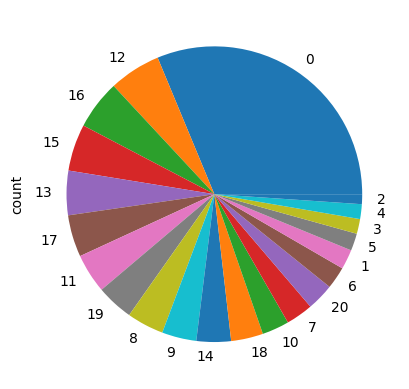

In [20]:
df.Arrondissement.value_counts().plot(kind="pie")

Un peu plus d'un quart des stations se trouve hors de Paris, nous pourrons par la suite la répartition des fréquentations par secteur géographique.

Même au sein de Paris, la répartition des stations de métro/RER n'est pas très homogène suivant les arrondissements. L'arrondissement de l'Ecole des Mines n'est pas bien doté en stations de métro/RER.

### Répartition des stations par ligne

Noter qu'une station desservie par plusieurs lignes compte pour chaque ligne. On utilise la méthode ```query``` pour sélectionner les stations de chaque ligne, puis on les compte. Pour le RER, notamment le A, il y a des doublons (GARE DE LYON/GARE DE LYON-RER).

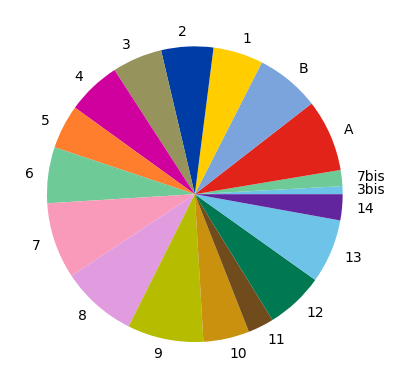

In [21]:
nb_stations = [df.query(f"desserte_{i}").shape[0] for i in l]  # liste des données
plt.figure()
couleurs = ["#6ec4e8", "#6eca97", "#e2231a", "#7ba3dc", '#ffcd00', '#003ca6', '#96935c', '#cf009e', '#ff7e2e', '#6eca97', '#fa9aba',
    '#e19bdf', '#b6bd00', '#c9910d', '#704b1c', '#007852', '#6ec4e8', '#62259d']  # couleurs des lignes selon la nomenclature RATP
plt.pie(nb_stations, labels=l, colors=couleurs)
plt.show()

*Sources pour les couleurs : [codes couleurs](https://www.photoshoplus.fr/couleurs/couleurs-ratp/) et [nuancier RATP](http://vexil.prov.free.fr/emblemes/metro_parisien.html).*

In [22]:
df.query("desserte_A & Réseau == 'Métro'")

,Rang,Réseau,Trafic,C1,C2,C3,C4,C5,Ville,Arrondissement,...,desserte_6,desserte_7,desserte_8,desserte_9,desserte_10,desserte_11,desserte_12,desserte_13,desserte_14,Nombre_lignes
Station,,,,,,,,,,,,,,,,,,,,,
GARE DE LYON,3,Métro,28640475,1,14,A,0,0,Paris,12,...,False,False,False,False,False,False,False,False,True,3


In [23]:
df.query("desserte_B & Réseau == 'Métro'")

,Rang,Réseau,Trafic,C1,C2,C3,C4,C5,Ville,Arrondissement,...,desserte_6,desserte_7,desserte_8,desserte_9,desserte_10,desserte_11,desserte_12,desserte_13,desserte_14,Nombre_lignes
Station,,,,,,,,,,,,,,,,,,,,,


Il n'y a qu'un seul doublon sur le RER A, et aucun sur le RER B.

## Trafic entrant par ligne, version "brute"
### Avec un camembert

Les données de la RATP ne précisant que le trafic entrant par ligne, sans distinguer la ligne, nous allons faire l'hypothèse, pour simplifier, que le trafic se répartit uniformément entre les lignes. Par exemple, à GARE DE LYON, $\frac 13$ des voyageurs se dirigent vers le métro 1, $\frac 13$ vers le métro 14 et $\frac 13$ vers le RER A. La division se fera avec ```//```, c'est-à-dire en omettant le reste (ce qui n'est pas fondamentalement grave au vu des nombres manipulés).

In [24]:
trafic_entrant_par_ligne = []
for ligne in l:
    data = df.query(f"desserte_{ligne}")
    Trafic = 0
    for station in data.index:
        Trafic = Trafic + data.loc[[station], "Trafic"].values[0]//data.loc[[station], "Nombre_lignes"].values[0]
    trafic_entrant_par_ligne.append(Trafic)

In [25]:
trafic_entrant_par_ligne

[4652652,
 5363221,
 183536799,
 99500372,
 86282322,
 56790088,
 56357063,
 95089643,
 70878639,
 51644032,
 84268900,
 71473732,
 93572263,
 31796910,
 28110482,
 60674406,
 83039402,
 55491324]

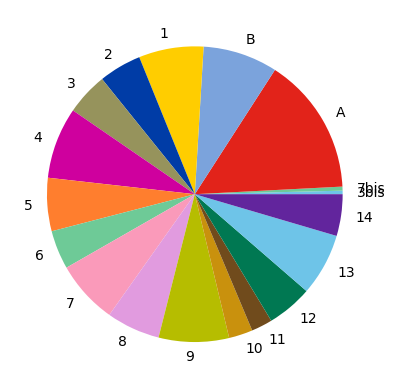

In [26]:
plt.figure()
plt.pie(trafic_entrant_par_ligne, labels=l, colors=couleurs)
plt.show()

Les deux lignes de RER (sur la partie RATP seulement) représentent presque 25% du trafic entrant sur le réseau RATP ! Sans surprise, le RER A est la ligne avec le plus de trafic entrant. À noter que la somme du trafic entrant sur le deux lignes bis est bien plus faible que celui sur les lignes 10 ou 11, elles-même avec un trafic entrant plutôt faible.

### Avec un diagramme en bâtons

Nous pouvons donc déjà en déduire que le trafic entrant est inégal suivant les lignes.

On peut également créer un ```data frame``` avec les données de fréquentation par ligne afin de facilier le traitement statistique.

In [27]:
donnees = {"Ligne" : l, "Trafic" : trafic_entrant_par_ligne}
trafic = pd.DataFrame(donnees)
trafic = trafic.set_index("Ligne")

<Axes: xlabel='Ligne'>

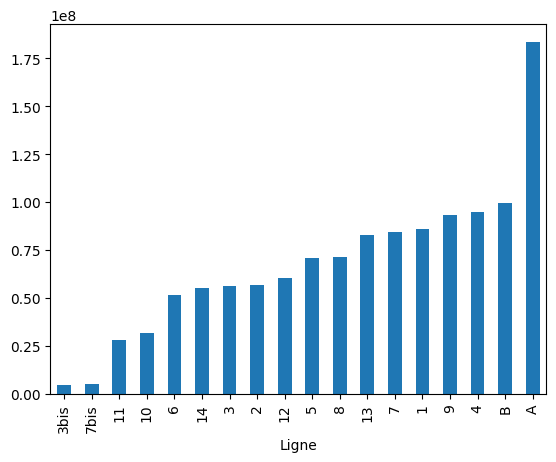

In [28]:
correspondance_couleurs = {l[k] : couleurs[k] for k in range(18)}
serie_couleurs = pd.Series(couleurs, trafic.index)  # création de la série
trafic["Couleur"] = serie_couleurs  # ajout au data frame
trafic.Trafic.sort_values(axis = "index").plot(kind="bar")

On peut voir ci-dessus le trafic entrant représenté sous la forme d'un diagramme en bâtons. Le RER A a deux fois plus de trafic entrant que le RER B !

On peut aussi mettre des couleurs aux lignes.

<Axes: xlabel='Ligne'>

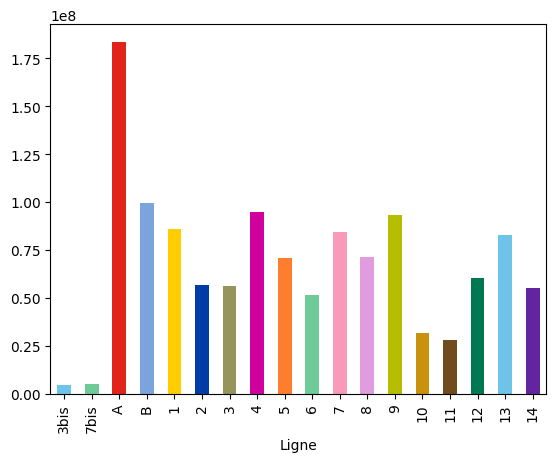

In [29]:
trafic.Trafic.plot(kind="bar",color=couleurs)

En revanche, mettre l'argument de couleurs après ```.sort_values``` mélange les couleurs...

Une autre méthode consiste à changer l'ordre des couleurs.

<Axes: xlabel='Ligne'>

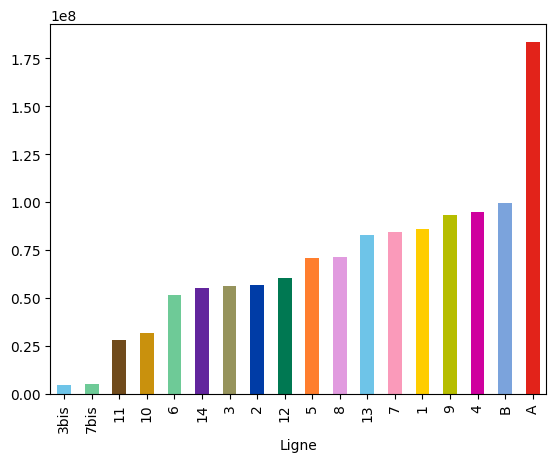

In [30]:
couleurs_ordre_trafic = []
for i in trafic.Trafic.sort_values().index:  # parcours des lignes dans l'ordre croissant du Trafic entrant
    couleurs_ordre_trafic.append(correspondance_couleurs[i])
trafic.Trafic.sort_values(axis = "index").plot(kind="bar",color=couleurs_ordre_trafic)

## Trafic entrant par ligne, version plus jolie
Ici, nous allons utiliser uniquement des méthodes de ```pandas```.

Nous allons diviser le trafic entrant par station par le nombre de lignes desservant cette station, mais nous allons pour cela dans un premier temps copier la dataframe ```df```.

In [31]:
df_par_ligne = df.copy()
df_par_ligne.Trafic = df_par_ligne.Trafic//df_par_ligne.Nombre_lignes

Nous allons créer un DataFrame du trafic par ligne. Pour cela, nous allons isoler le trafic de chaque ligne avec ```groupby("desserte_ligne").sum()```, en faire un DataFrame, changer l'```Index``` en ```Ligne```, et remplacer le ```True``` par le numéro de la ligne en question, et enfin concaténer tous les DataFrame obtenus.

In [32]:
ligne = "3bis"
a = df_par_ligne.groupby("desserte_"+ligne).sum()  # obtenir le trafic entrant total d'une ligne
trafic_ligne = pd.DataFrame(a.Trafic)  # création d'un DataFrame
trafic_ligne = trafic_ligne.drop(False)  # suppression du trafic entrant ne concernant pas la ligne
trafic_ligne.index = [ligne]  # True est remplacé par le numéro de la ligne
trafic_ligne = trafic_ligne.rename_axis("Ligne")  # l'index est renommé Ligne

for ligne in l[1:]:  # parcours des lignes autres que la 3bis
    a = df_par_ligne.groupby("desserte_"+ligne).sum()
    s = pd.DataFrame(a.Trafic)
    s = s.drop(False)
    s.index = [ligne]
    s = s.rename_axis("Ligne")
    trafic_ligne = pd.concat([trafic_ligne,s])  # concaténation des DataFrame

Vérifions que cette méthode donne le même résultat que la méthode précédente.

In [33]:
pd.merge(trafic_ligne, trafic, on = "Ligne")

,Trafic_x,Trafic_y,Couleur
Ligne,,,
3bis,4652652,4652652,#6ec4e8
7bis,5363221,5363221,#6eca97
A,183536799,183536799,#e2231a
B,99500372,99500372,#7ba3dc
1,86282322,86282322,#ffcd00
2,56790088,56790088,#003ca6
3,56357063,56357063,#96935c
4,95089643,95089643,#cf009e
5,70878639,70878639,#ff7e2e


On obtient bien le même résultat. On obtient donc les mêmes graphiques.

## Répartition du trafic par station à l'intérieur de chaque arrondissement

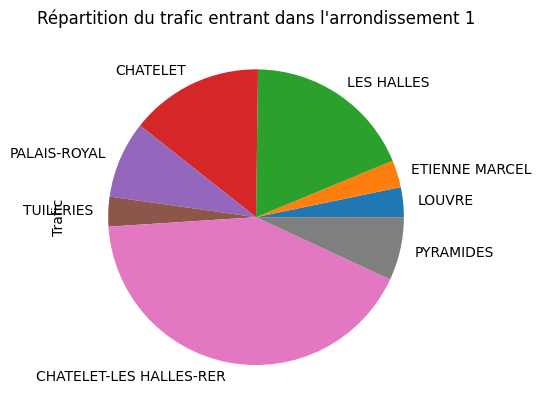

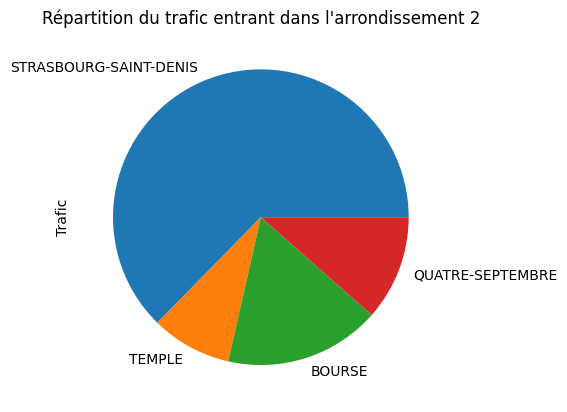

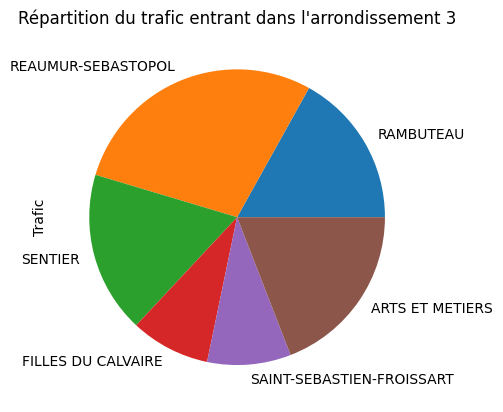

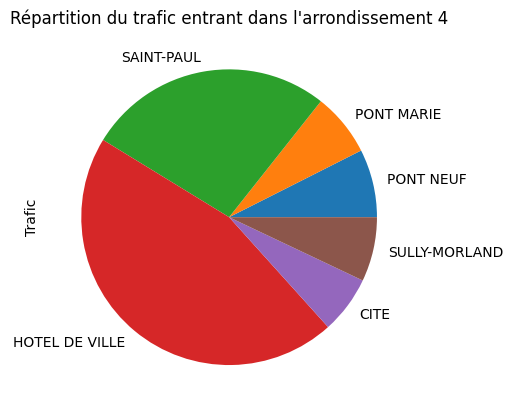

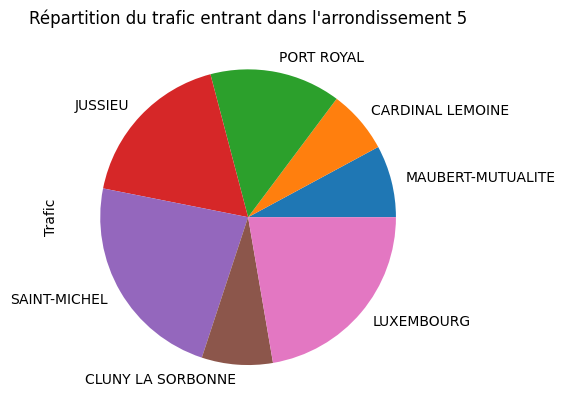

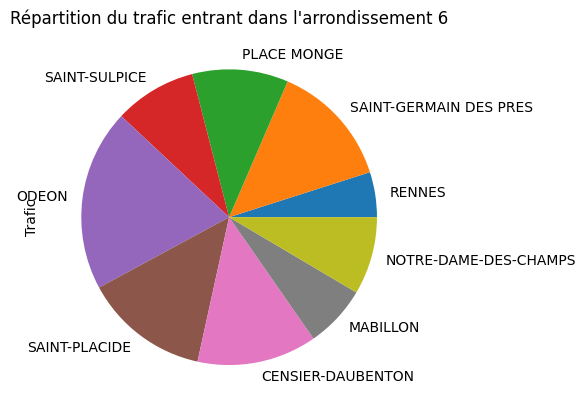

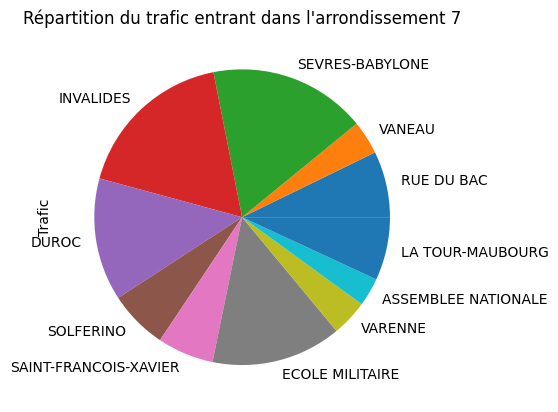

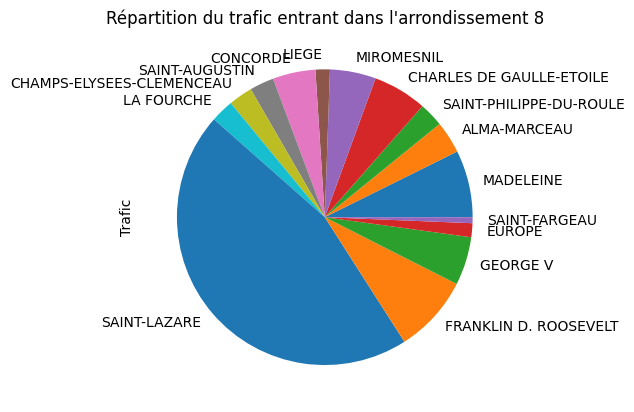

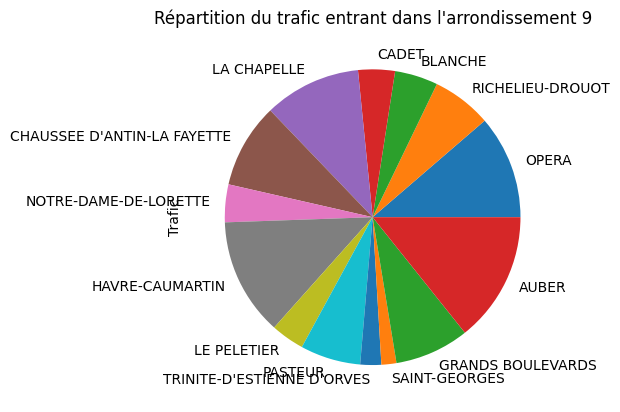

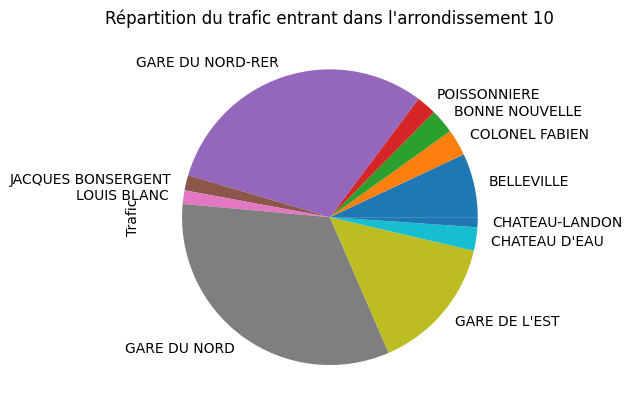

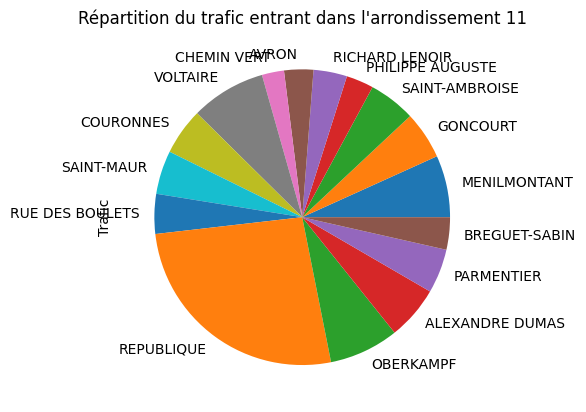

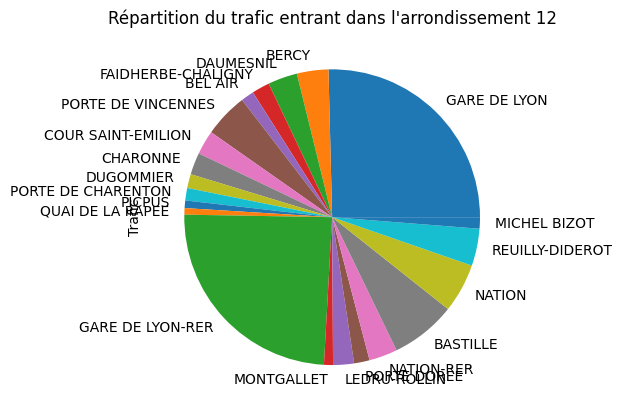

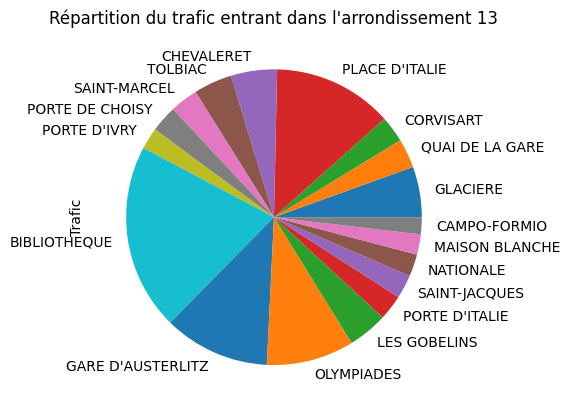

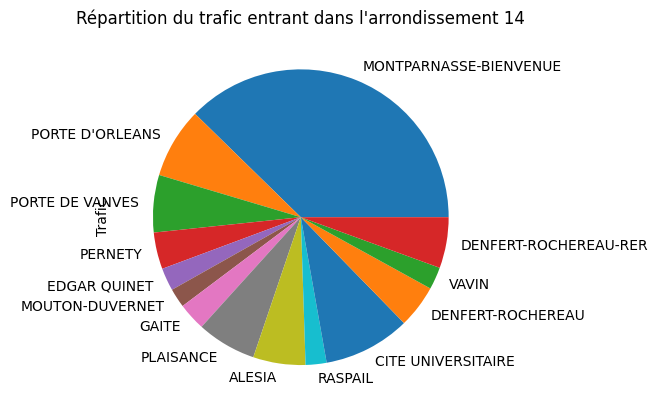

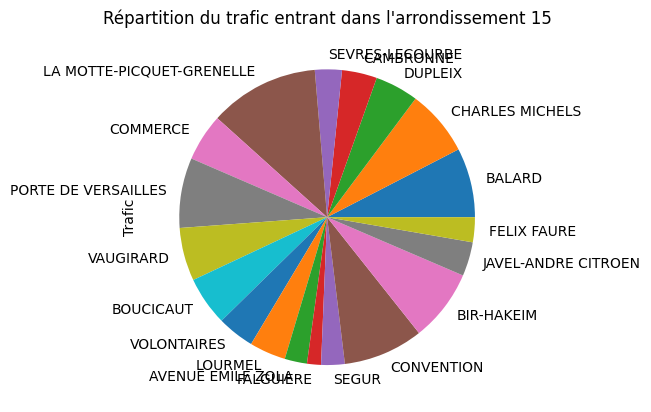

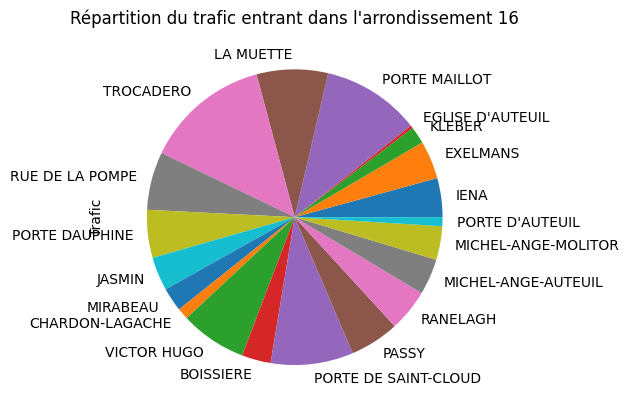

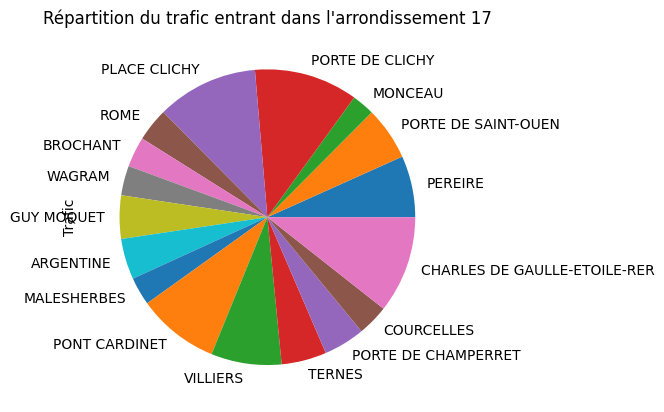

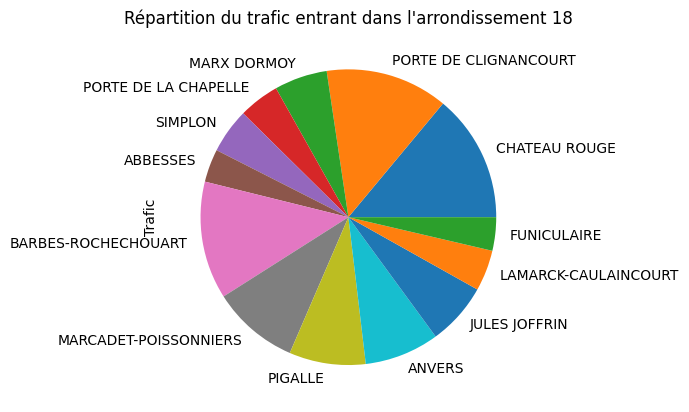

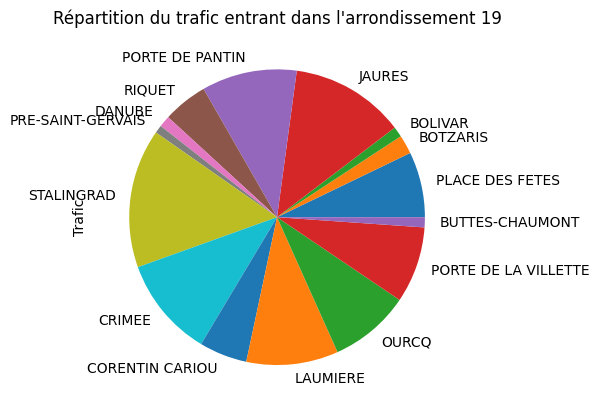

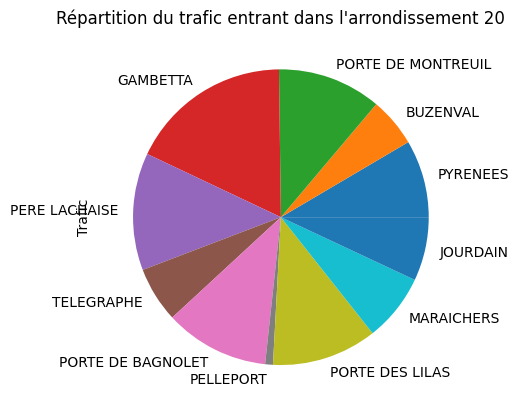

In [34]:
arrondissements = list(range(1,21))
for a in arrondissements:
    df.query("Arrondissement == "+str(a)).Trafic.plot(kind="pie",title = "Répartition du trafic entrant dans l'arrondissement "+str(a))
    plt.show()

## Trafic entrant par arrondissement
Nous allons nous intéresser à la répartition par arrondissement du trafic entrant sur le réseau RATP. Pour cela, on utilise la méthode ```groupby()``` afin de regrouper les stations d'un même arrondissement, et sommer les trafics. Notons que la commande va aussi sommer le reste, mais cela ne pose pas de problème vu que c'est la seule donnée du trafic entrant qui nous intéresse. Pour rappel, l'arrondissement 0 correspond aux stations hors de Paris.

<Axes: ylabel='Trafic'>

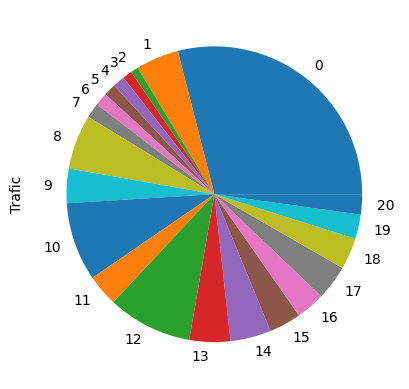

In [35]:
par_arrondissement = df.groupby("Arrondissement").sum()
par_arrondissement.Trafic.plot(kind="pie")

On peut également représenter les valeurs triées sur un diagramme en bâtons.

<Axes: xlabel='Arrondissement'>

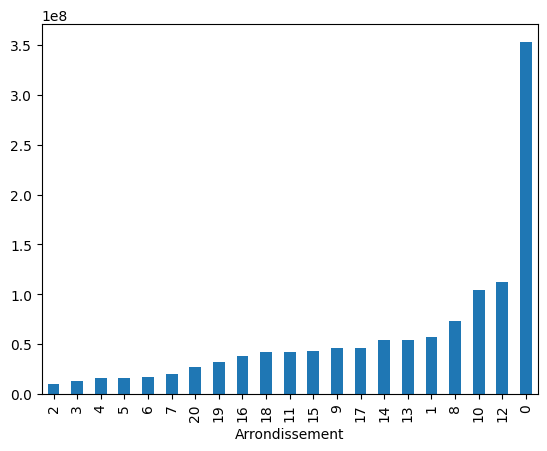

In [36]:
par_arrondissement.Trafic.sort_values().plot(kind="bar")

Le sixième arrondissement ne se trouve pas en bonne position...
## Pour finir

Regardons la description statistique du trafic par station.

In [37]:
df.Trafic.describe()

count    3.710000e+02
mean     3.284427e+06
std      4.175318e+06
min      1.249410e+05
25%      1.532653e+06
50%      2.291843e+06
75%      3.556971e+06
max      3.450310e+07
Name: Trafic, dtype: float64

<Axes: xlabel='Trafic', ylabel='Fréquence'>

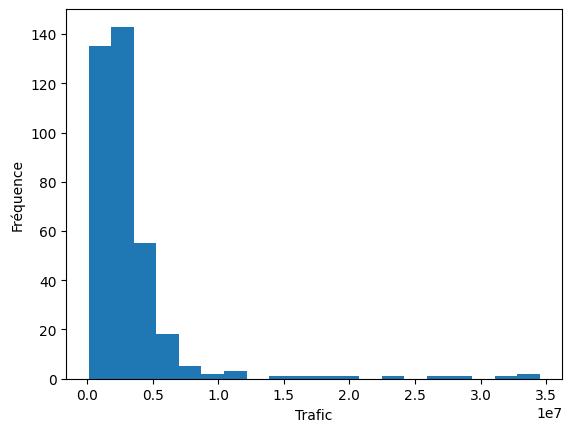

In [47]:
df.Trafic.plot(kind="hist",bins = 20,xlabel="Trafic",ylabel="Fréquence")

Notons une forte disparité entre les stations : l'écart-type est du même ordre de grandeur que la moyenne (même plus grand).